# Notebook: Modelling a bivariate relationship
*Description:* This notebook explores a bivariate relationship between a dependent variable `cost_fl_area` (the average property cost per square metre in an LSOA geographic area) and an independent variable `count_list` (the number of short-term rental [STR] listings in a LSOA geographic area) using standard Linear Regression, Random Forest, and Decision Tree modelling approaches.

This is the first of three notebooks that apply a modelling approach to the data we have sourced, cleaned, and collated.

For more information on LSOA geographic areas, consult the [Compose Data](https://colab.research.google.com/drive/1utDtpkmgJnKhD5-8t7_jDoNIPnfgX4Mi?usp=sharing) notebook.

*Data:* Input data `lsoa_summaries` is used as input to this analysis workflow. This data is produced as the result of collation, cleaning, and compilation of other foundational datasets in the Compose Data notebook. The input data comprises 1,885 rows (summarized at a LSOA geographic unit from `listings` and `properties` data each comprising >= 50,000 rows). The following features are included in the dataset:

```
LSOA11CD: Given LSOA code, 2011 boundaries
avg_str_price: The average price (by night) of a STR property within the LSOA
cost_fl_area: The average cost by floor area (m^2) of a property within the LSOA
count_prop: The count of properties within the LSOA boundary
count_list: The count of STR listings within the LSOA boundary
borough: The borough (local government authority) to which the LSOA is a part
imd_score: The index of multiple deprivation (cumulative) score, UK Index of Deprivation (ID)
income_score: The income deprivation score, UK ID
employ_score: The employment deprivation score, UK ID
educ_score: The education, skills and training score, UK ID
health_score: The health deprivation and disability score, UK ID
crime_score: The crime deprivation score, UK ID
house_score: The barriers to housing and services score, UK ID
env_score: The living environment score, UK ID
```

*Return:* The result of this notebook is a series of regression models ([standard OLS linear regression](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html), [DecisionTreeRegression](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), [RandomForestRegression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) demonstrating the bivariate relationship between `count_list`  and `cost_fl_area` .

We also develop a basic predictive function `calculate_cost_increase` derived from the modelling approach to demonstrate the relationship given initial cost per square metre, some number of STR listings, and a percentage by which to increase cost.


#1. Initialization
*Description:* In this section, we install or import packages, initialize filepath, and load the project dataset `lsoa_summaries` into a Pandas dataframe.

*Return:* `main_df`, a Pandas dataframe comprising the data loaded from .csv
file `lsoa_summaries`.

In [1]:
!pip install --upgrade pip --user
!pip install pydotplus --user
!pip install graphviz --user
!pip install ipython --user
!sudo apt-get install graphviz
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.1 MB/s eta 0:00:00


In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns

# mapping functionality
import contextily as cx
import geopandas as gpd

# modelling
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
import matplotlib.pyplot as plt

#Trees
from sklearn import tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#Linear Models
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm

#Cross Validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

#Model tuning
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filepath_lsoa = "/content/drive/MyDrive/CIS5450/Term_Project/data/lsoa_summaries.csv"
filepath_shp = "/content/drive/MyDrive/CIS5450/Term_Project/data/shapefile/LSOA_2011_London_gen_MHW.shp"

In [4]:
# load lsoa_summaries data into main_df dataframe

main_df = pd.read_csv(filepath_lsoa)
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1885 non-null   int64  
 1   LSOA11CD       1885 non-null   object 
 2   avg_str_price  1885 non-null   float64
 3   cost_fl_area   1885 non-null   float64
 4   count_prop     1885 non-null   int64  
 5   count_list     1885 non-null   int64  
 6   borough        1885 non-null   object 
 7   imd_score      1885 non-null   float64
 8   income_score   1885 non-null   float64
 9   employ_score   1885 non-null   float64
 10  educ_score     1885 non-null   float64
 11  health_score   1885 non-null   float64
 12  crime_score    1885 non-null   float64
 13  house_score    1885 non-null   float64
 14  env_score      1885 non-null   float64
dtypes: float64(10), int64(3), object(2)
memory usage: 221.0+ KB


In [5]:
# print first three rows to understand shape
main_df.head(3)

,Unnamed: 0,LSOA11CD,avg_str_price,cost_fl_area,count_prop,count_list,borough,imd_score,income_score,employ_score,educ_score,health_score,crime_score,house_score,env_score
0,0,E01000001,137.90,13261.97,40,10,City of London,6.2,0.0,0.0,0.0,-1.7,-2.0,29.5,31.9
1,1,E01000002,180.87,14235.39,27,15,City of London,5.1,0.0,0.0,0.1,-1.1,-2.3,24.4,23.1
2,2,E01000003,81.07,13600.62,99,14,City of London,19.4,0.1,0.1,5.8,-0.1,-1.0,40.1,40.5


In [6]:
# drop unnamed index column and re-run print to ensure expected output
main_df = main_df.drop(columns=['Unnamed: 0'])
main_df.head(2)

,LSOA11CD,avg_str_price,cost_fl_area,count_prop,count_list,borough,imd_score,income_score,employ_score,educ_score,health_score,crime_score,house_score,env_score
0,E01000001,137.90,13261.97,40,10,City of London,6.2,0.0,0.0,0.0,-1.7,-2.0,29.5,31.9
1,E01000002,180.87,14235.39,27,15,City of London,5.1,0.0,0.0,0.1,-1.1,-2.3,24.4,23.1


#2. Exploratory data analysis

*Description:* In this section, we conduct exploratory data analysis to understand the basic descriptive statistics of the project dataset, the distribution of the contained data, and perform some cartographic analysis to identify "hot spots" among the LSOA in the inner London study area.

*Data:* We use the following data within this section:

* Input data `lsoa_summaries` as `main_df` dataframe
* LSOA 2011 boundary shapefile for Greater London [(GLA, 2019)](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)

*Return:* A series of data visualizations, with reference to four cartographic products:
* Average STR price by LSOA geographic unit, 2015-2020
* Average cost per square metre of property by LSOA geographic unit, 2017-2019
* Count of properties by LSOA geographic unit, 2019-2020
* Count of STR listings by LSOA geographic unit, 2019-2020

**Descriptive Statistics:** Here we observe the basic descriptive statistics that characterize `main_df`. We note mean values of £112.00 per night to rent an STR in inner London, £8,040.00 average cost per floor area, and an average 30 properties and 35 listings per each LSOA.

At first glance, the latter seems irreconcilable! However, we note that as LSOA is tailored to population, the number of residential properties measured in `count_prop` does not necessarily correspond to the broader extent of listings in `count_list` (which can include commercial properties outside of standard residential permitting and land use contexts).

Similarly, LSOA with outlier minimum values only denote that a minimum number of properties has been sold during our study period of 2017-2019-not that there is only one property per LSOA.

In [7]:
# gather descriptive statistics respecting each feature in dataset
main_df.describe()

,avg_str_price,cost_fl_area,count_prop,count_list,imd_score,income_score,employ_score,educ_score,health_score,crime_score,house_score,env_score
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,112.817915,8040.781443,30.471088,35.379841,24.761008,0.155225,0.098249,11.849337,-0.112785,0.408859,32.005570,35.379151
std,73.623401,3192.529282,16.979813,37.110525,10.137628,0.085216,0.058121,8.655917,0.728442,0.561524,9.152455,10.710957
min,15.000000,2005.210000,1.000000,1.000000,3.600000,0.000000,0.000000,0.000000,-3.200000,-2.300000,10.200000,10.300000
25%,69.000000,5868.950000,18.000000,14.000000,17.000000,0.100000,0.100000,4.800000,-0.400000,0.100000,25.400000,28.000000
50%,95.450000,7506.170000,28.000000,26.000000,25.000000,0.200000,0.100000,10.200000,0.000000,0.400000,30.700000,34.200000
75%,134.630000,9238.660000,41.000000,44.000000,32.200000,0.200000,0.100000,17.500000,0.400000,0.800000,38.000000,41.100000
max,1146.770000,24356.000000,117.000000,440.000000,59.000000,0.400000,0.300000,59.000000,1.600000,2.100000,64.200000,91.600000


**Cartographic exploration:** We now consider the different LSOA summaries from a spatial perspective by mapping each of the property and listing features as a cartographic visualization. We will introduce an LSOA shapefile, merge it to `main_df` to join geometry to data, and then output using the [Geopandas](https://geopandas.org/en/stable/) library.

In [8]:
# get unique boroughs in dataset
boroughs = main_df.borough.unique()
print("Unique boroughs in dataset: ", boroughs)

Unique boroughs in dataset:  ['City of London' 'Camden' 'Greenwich' 'Hackney' 'Hammersmith and Fulham'
 'Islington' 'Kensington and Chelsea' 'Lambeth' 'Lewisham' 'Newham'
 'Southwark' 'Tower Hamlets' 'Wandsworth' 'Westminster']


In [9]:
# read LSOA shapefile data and filter by subject boroughs
geo_data = gpd.read_file(filepath_shp)
fil_data = geo_data[geo_data['LAD11NM'].isin(boroughs)]

In [10]:
# create a merged dataset using the main_df data
fil_data_m = fil_data.merge(main_df, on="LSOA11CD", how="inner")
# print first two rows for confirmation
fil_data_m.head(2)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,count_list,borough,imd_score,income_score,employ_score,educ_score,health_score,crime_score,house_score,env_score
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,10,City of London,6.2,0.0,0.0,0.0,-1.7,-2.0,29.5,31.9
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,15,City of London,5.1,0.0,0.0,0.1,-1.1,-2.3,24.4,23.1


**Average STR price by LSOA**: In this visualization, we observe general consistency of STR pricing across our inner London study area. The notable exceptions rest in the LSOas found within the historically expensive boroughs of Kensington and Chelsea, and Westminster.

Text(0.0, 1.0, 'Average STR price by LSOA geographic unit, 2015-2020')

<Figure size 1000x1000 with 0 Axes>

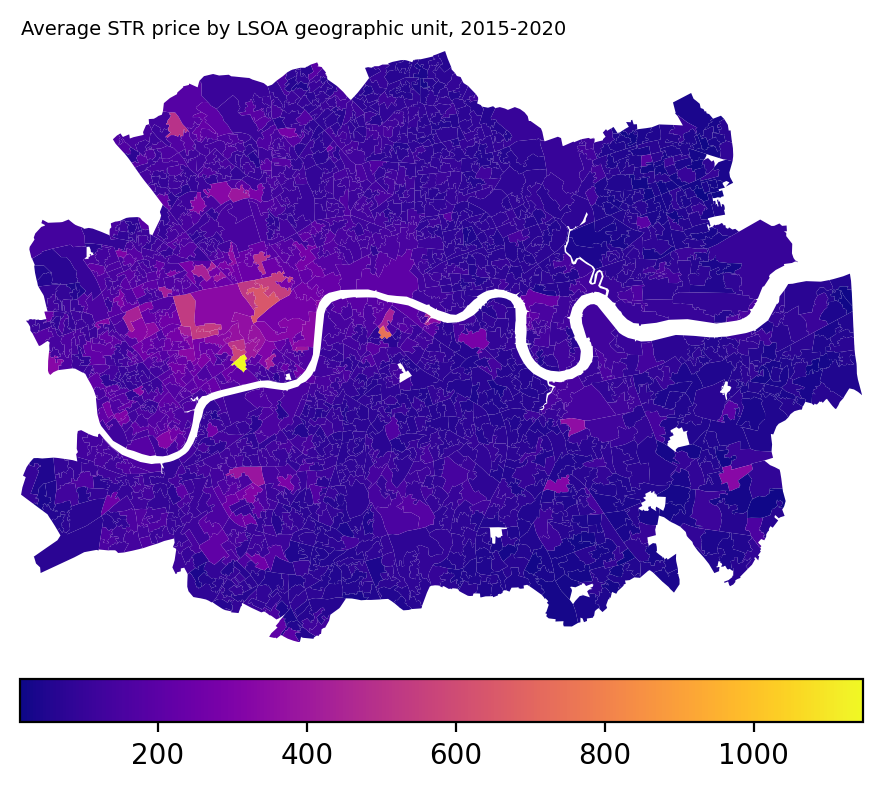

In [11]:
# set figure dimensions
plt.figure(figsize=(10, 10))
plt.rcParams['figure.dpi'] = 200
plt.tight_layout()

# LAYER MANAGEMENT
# plot avg STR price by LSOA
a_str = fil_data_m.plot(column="avg_str_price", cmap="plasma", legend=True, legend_kwds={'shrink': 0.85, 'orientation': 'horizontal', 'pad': 0.05})

# set axis, figure and show
a_str.set_axis_off()
a_str.margins(0)
a_str.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, labelsize='small')
mtitle = "Average STR price by LSOA geographic unit, 2015-2020"
a_str.set_title(mtitle, fontsize=7, loc='left')

**Average cost per square metre by LSOA**: In this visualization, we observe the clear westward skew of property valuation in inner London, again with the boroughs of Kensington and Chelsea, and Westminster leading the way in terms of cost per square metre. Conversely, we observe comparatively lower values in the eastern part of inner London.

Text(0.0, 1.0, 'Average cost per square metre of property by LSOA geographic unit, 2017-2019')

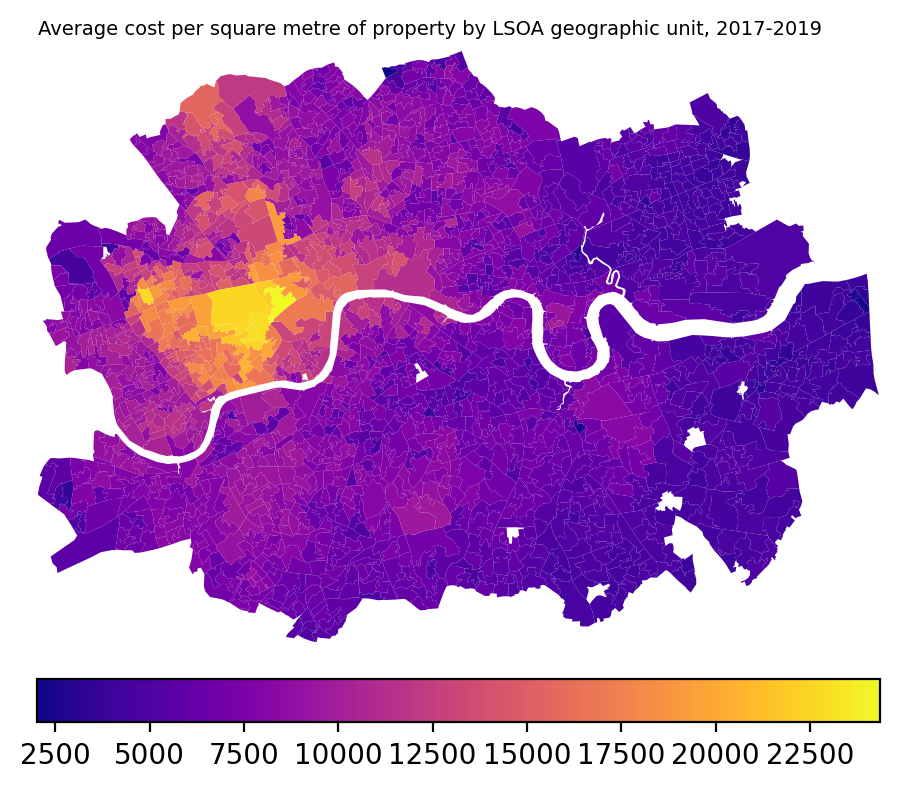

In [12]:
# LAYER MANAGEMENT
# plot avg cost per square metre by LSOA
a_cfl = fil_data_m.plot(column="cost_fl_area", cmap="plasma", legend=True, legend_kwds={'shrink': 0.85, 'orientation': 'horizontal', 'pad': 0.05})

# set axis, figure and show
a_cfl.set_axis_off()
a_cfl.margins(0)
a_cfl.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, labelsize='small')
mtitle = "Average cost per square metre of property by LSOA geographic unit, 2017-2019"
a_cfl.set_title(mtitle, fontsize=7, loc='left')

**Count of properties by LSOA**: In this visualization, we observe a greater number of properties sold in south London, which may suggest a higher overall density of properties.

Text(0.0, 1.0, 'Count of properties by LSOA geographic unit, 2019-2020')

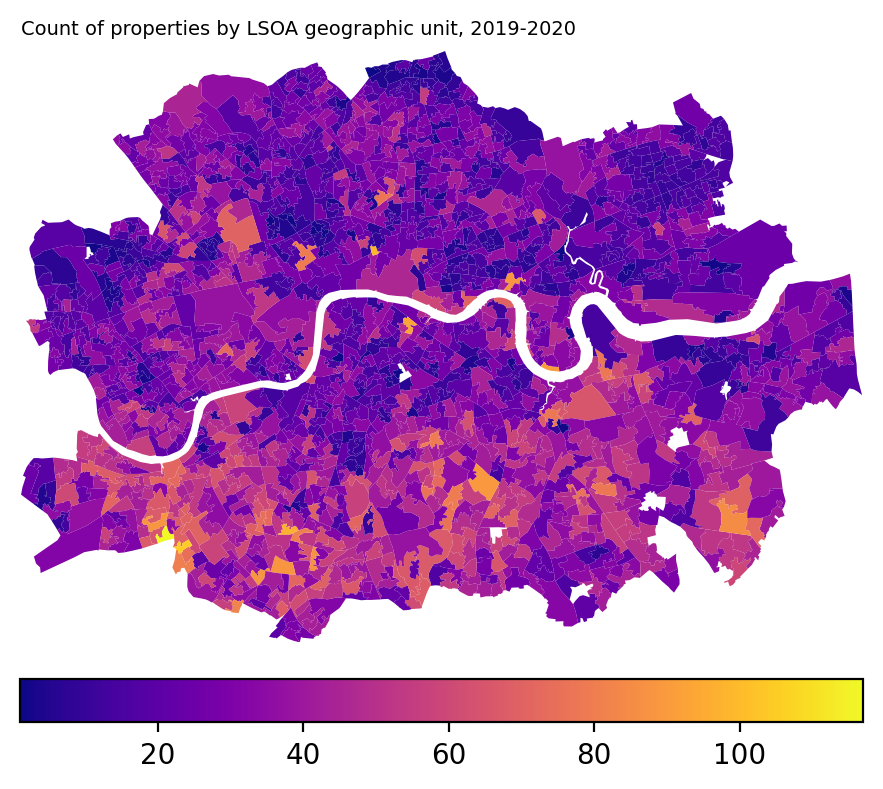

In [13]:
# LAYER MANAGEMENT
# plot count of overall properties by LSOA
co_p = fil_data_m.plot(column="count_prop", cmap="plasma", legend=True, legend_kwds={'shrink': 0.85, 'orientation': 'horizontal', 'pad': 0.05})

# set axis, figure and show
co_p.set_axis_off()
co_p.margins(0)
co_p.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, labelsize='small')
mtitle = "Count of properties by LSOA geographic unit, 2019-2020"
co_p.set_title(mtitle, fontsize=7, loc='left')

**Count of STR listings by LSOA**: In this visualization, we (perhaps unsurprisingly) observe the highest number of STR listings in inner London are located in the City of London (as the financial centre of the UK) and west London (as the historic centre of tourism in the capital).

Text(0.0, 1.0, 'Count of STR listings by LSOA geographic unit, 2019-2020')

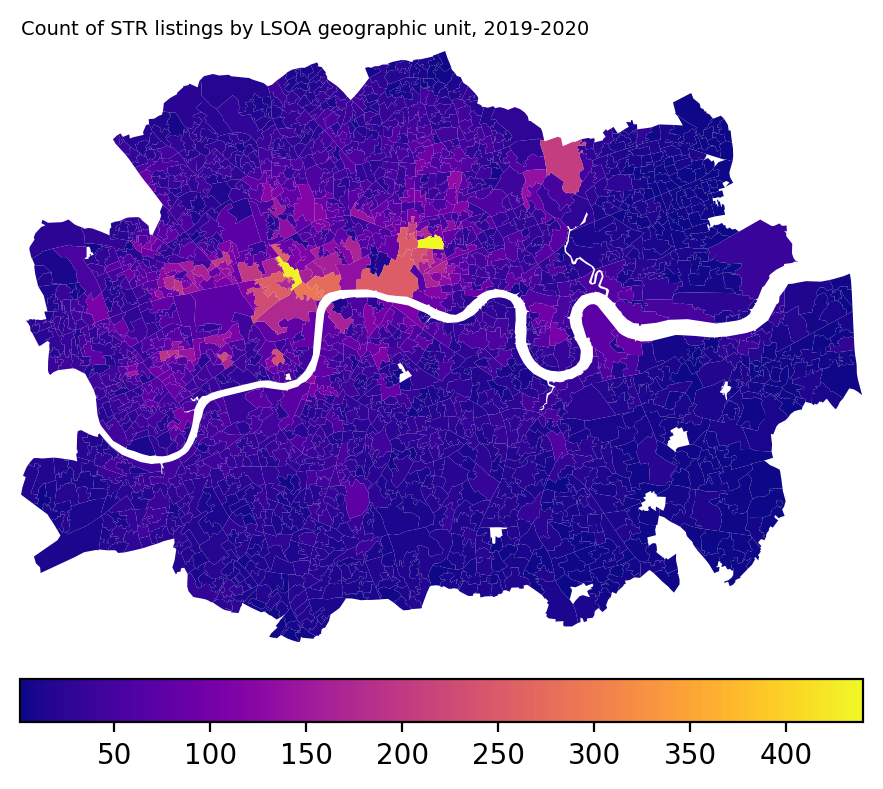

In [14]:
# LAYER MANAGEMENT
# plot STR frequency
co_l = fil_data_m.plot(column="count_list", cmap="plasma", legend=True, legend_kwds={'shrink': 0.85, 'orientation': 'horizontal', 'pad': 0.05})

# set axis, figure and show
co_l.set_axis_off()
co_l.margins(0)
co_l.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, labelsize='small')
mtitle = "Count of STR listings by LSOA geographic unit, 2019-2020"
co_l.set_title(mtitle, fontsize=7, loc='left')

#3. Modelling using linear regression
*Description*: In this section, we explore the overarching research question: **"Is an active (dense) STR sector within a LSOA geographic unit positively correlated with increased housing costs in the same unit?"**

We begin by exploring all features as independent variables with the ultimate goal to drop those that we do not need. The dependent variable as price per square meter `cost_fl_area`.

*Data:* Using `main_df`, we consider on a trial basis a multi-regression model using the following dataframe features:
*   `count_list` - the number of listings per LSOA11CD within each borough
*  ` count_prop` - count of properties in the area
*   `imd_score` - scores for index of multiple deprivation

We hypothesize that our preliminary model could be:

 $$ \text{Cost per metre square} \approx \beta_0+\beta_1 X_{\text{count_list}}+\beta_2 X_{\text{count_prop}}+\beta_3 X_{\text{imd_score}}+\epsilon$$


In [15]:
# copy the main dataframe for exploratory purposes
data_copy = main_df.copy()
# from our copy, build a feature set according to the above specification
X_2 = data_copy[['count_list', 'count_prop', 'imd_score']]

# run ordinary least squares function to instantiate model
model_2 = smf.ols('cost_fl_area ~' + ' + '.join([i for i in X_2.columns]), data=data_copy)
# fit the model
res = model_2.fit()

# print the resulting OLS summary
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           cost_fl_area   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     483.8
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          5.64e-233
Time:                        17:39:07   Log-Likelihood:                -17344.
No. Observations:                1885   AIC:                         3.470e+04
Df Residuals:                    1881   BIC:                         3.472e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.196e+04    284.999     41.956      0.0


For every unit increase in the number of STR listings, the cost per square metre increases by 37 per cent. We could express this in a basic predictive function using the following Python code:



In [16]:
# Given initial cost per square metre, a number of STR listings, and a percentage
# by which to increase cost, function calculates the cost per square metre increase.

def calculate_cost_increase(initial_cost_per_sqm, num_STR_listings, increase_percentage):
    # calculate the updated cost per square meter
    updated_cost_per_sqm = initial_cost_per_sqm * (1 + increase_percentage * num_STR_listings)
    return updated_cost_per_sqm

# example usage:
initial_cost = 100    # initial cost per square meter
num_listings = 3      # number of STR listings
increase_pct = 0.37   # percentage by which to increase cost

# get cost increase from function
cost_increase = calculate_cost_increase(initial_cost, num_listings, increase_pct)
print(f"The cost increase per square metre is: {cost_increase}")

The cost increase per square metre is: 211.0


**Model iteration:** Our original study question was to see if an active (dense) STR sector would impact price paid for a property. We remove all features but `count_list` (as independent variable) and assume the true mathematical model is given by:

$$ \text{Cost per }m^2 \approx \beta_0+\beta_1 X_{\text{count_list}}+\epsilon$$


In [17]:
# from our copy, build a feature set according to the above specification
X_1 = data_copy[['count_list']]

# run ordinary least squares function to instantiate model
model = smf.ols('cost_fl_area ~ count_list', data=data_copy)
# fit the model
res = model.fit()

# print the resulting OLS summary
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           cost_fl_area   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     598.5
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          5.33e-115
Time:                        17:39:07   Log-Likelihood:                -17623.
No. Observations:                1885   AIC:                         3.525e+04
Df Residuals:                    1883   BIC:                         3.526e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6546.0639     88.534     73.938      0.0

In the simplified bivariate model, for every unit increase in the number of STR listings, the cost per square metre increases by 42 per cent. We will move forward with this model for further exploration per our starting study question.

In the below cell, we observe a simple substitution of values for `increase_pct` aligns our predictive function with the model output above.

In [18]:
# example usage:
initial_cost = 100    # initial cost per square meter
num_listings = 3      # number of STR listings
increase_pct = 0.42   # percentage by which to increase cost

# get cost increase from function
cost_increase = calculate_cost_increase(initial_cost, num_listings, increase_pct)
print(f"The cost increase per square metre is: {cost_increase}")

The cost increase per square metre is: 225.99999999999997


# 4. Modelling using Decision Tree and Random Forest Regressions
*Description:* In this section, we explore application of Decision Tree and Random Forest Regression approaches to our bivariate model established in the prior section. Our motivation rests in the low R-squared score of the standard linear regression model.

*Data:* Using the copy of `main_df`, we use a bivariate model with `count_list`, or the number of listings per LSOA11CD within each borough, as independent variable and `cost_fl_area`, or the average property cost per square metre in an LSOA geographic area, as dependent variable.

*Return:* Linear regression models using Decision Tree and Random Forest Regression approaches (via [SciKit-Learn](https://scikit-learn.org/stable/)) for analysis.

**Split the testing and training data:** In this section, we split the copy of `main_df` into testing and training datasets. Considerations are as follows:
* The number of STR listings `count_list` as feature column, will be treated as X.

* We will not be scaling the data for now as our first model will be a Random Forest, which is scale-invariant.

* 80 per cent of the data will be used for training, 20 per cent of the data will be used for testing.

The following template approach is used:

In [19]:
# generate independent variable - feature
final_X = data_copy[['count_list']]
# generate dependent variable - target
y = data_copy['cost_fl_area']

# split data into test/train
X_train, X_test, y_train, y_test = train_test_split(final_X, y, test_size=0.2, random_state=42)

**Decision Tree Regression:** In the following section, we run the Decision Tree Regression using SciKit-Learn [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) tools. We split into test/train datasets following the above template, then fit the Decision tree regression to the dataset and run the `predict` function. The aim is to fine-tune the depth of the tree to decrease the potential for over-fitting to provided data.

We then export a visualization of the tree to understand its depth and graph traversal process.

In [20]:
# generate independent variable - feature
final_X = data_copy['count_list'].values
# generate dependent variable - target
y = data_copy['cost_fl_area'].values

# split into test/train sets
X_train, X_test, y_train, y_test = train_test_split(final_X, y, test_size=0.2, random_state=42)


# Fitting Decision Tree Regression to the dataset
regressor = DecisionTreeRegressor()
regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

# get prediction
y_pred = regressor.predict(X_test.reshape(-1,1))

In [ ]:
# export decision tree visualization to understand depth and traversal
dot_data = tree.export_graphviz(regressor, out_file=None,
                            filled=True,
                            rounded=True,
                            special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

In [21]:
# model
regr_1 = DecisionTreeRegressor(max_depth=1)
regr_2 = DecisionTreeRegressor(max_depth=2)
regr_3 = DecisionTreeRegressor(max_depth=3)

# train
regr_1.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
regr_2.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
regr_3.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

# predict
y_1 = regr_1.predict(X_test.reshape(-1,1))
y_2 = regr_2.predict(X_test.reshape(-1,1))
y_3 = regr_3.predict(X_test.reshape(-1,1))

**Decision Tree mean-squared error (MSE)**: In this section, we plot the data and trialled tree-depths of the Decision Tree to understand the preferred `max_depth` and thus, the more suitable modelling approach.

We find of the trialled depths, a `max_depth` of 5 is more suitable for its balance of bias and variance and will provide us a better model of the bivariate relationship.

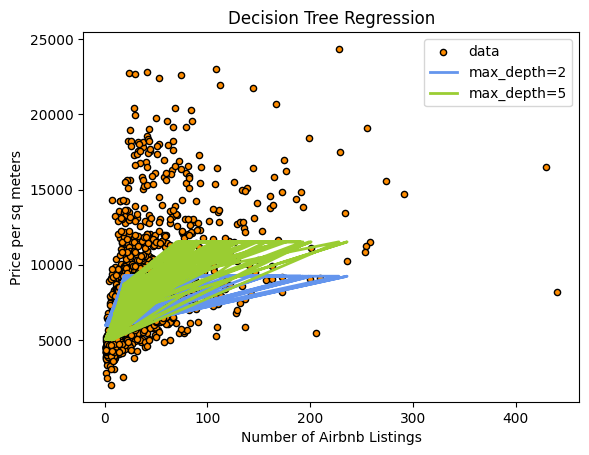

In [ ]:
plt.figure()
plt.scatter(final_X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("Number of Airbnb Listings")
plt.ylabel("Price per sq meters")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [22]:
# let's get the mse in order to evaluate performance
mse = metrics.mean_squared_error(y_test, y_3)

# root of mse - prediction error magnitude
rmse = mse**0.5

# print mean square error and root mean square deviation
print("Mean squared error, decision tree: ", mse)
print("Root mean squared error, decision tree: ", rmse)

Mean squared error, decision tree:  6791149.9363204595
Root mean squared error, decision tree:  2605.9834873460845


In [23]:
dt_score = metrics.r2_score(y_test, y_3)
print("R-squared score, decision tree (3): ", dt_score)

R-squared score, decision tree (3):  0.2775018476486063


**Random Forest Regression**: Although Random Forest is often used as a classification model, in this case, we select it for regression purposes using the SciKit-Learn `RandomForestRegressor` methods. Instead of predicting a label or class (as we might expect in a classification model), we use it to predict the cost-per-square metre.

We again export a visualization of the tree to understand its depth and graph traversal process.


In [ ]:
#Random Forest Classifier
regr = RandomForestRegressor()

# train the model
regr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

# make predictions
y_pred = regr.predict(X_test.reshape(-1,1))

<ipython-input-18-52c29124bb64>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))


In [ ]:
dot_data = tree.export_graphviz(regr.estimators_[99], out_file=None,
                            filled=True,
                            rounded=True,
                            special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

**Random Forest MSE:** We will again use MSE to measure the predictive efficacy of the model.

In [24]:
from sklearn import metrics

# let's get the mse in order to evaluate performance
mse = metrics.mean_squared_error(y_test, y_pred)

# root of mse - prediction error magnitude
rmse = mse**0.5

# print mean square error and root mean square deviation
print("Mean squared error, random forest: ", mse)
print("Root mean squared error, random forest: ", rmse)

Mean squared error, random forest:  7776734.143660726
Root mean squared error, random forest:  2788.6796416334246


In [25]:
rf_score = metrics.r2_score(y_test, y_pred)
print("R-squared score, random forest: ", rf_score)

R-squared score, random forest:  0.17264732735864896


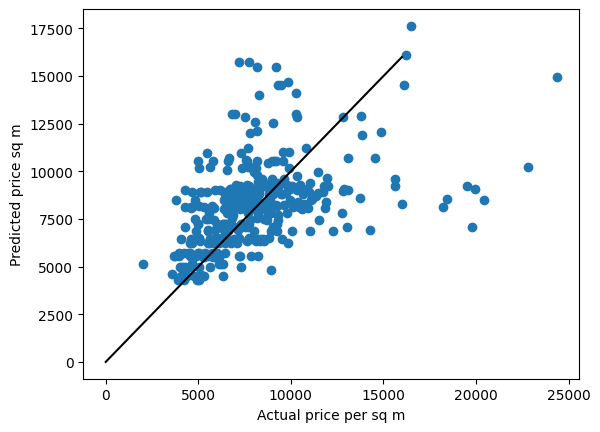

In [ ]:
# let's visualize the predictions against the actual values

plt.scatter(y_test, y_pred)
plt.ylabel('Predicted price sq m')
plt.xlabel('Actual price per sq m')
plt.plot([0,16000], [0,16000], 'black')

From the above, we see our plot indicates a better model than the decision tree despite a comparatively lower R-squared score. However, we posit that the presence of outliers is shaping the result of the root mean squared error calculation. We observe that the RMSE = 2,815.60, or the average error per estimate.

We now run this through a cross-validation process to find optimal hyperparameters (a value used to tune the learning process).

**Cross-validation to find the optimal values:** For our Random Forest model, we will optimize on the following hyperparameters:

* `max_depth`: maximum depth of each tree

* `max_features`: number of features for splitting

* `n_estimators`: number of trees to build


In [40]:
# build a dictionary of hyperparameter keys / values to combine and trial
param_grid = {
    'max_depth': [5,10,20],
    'max_features' : [5,10,20],
    'n_estimators': [20,50]}

**GridSearch CV**: First, we define the approach as described in the notebook for STR feature importance.

In `GridSearchCV`, we automate the tuning of hyperparameters in an [exhaustive search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). We will pass predefined values for hyperpararmeters to the function which will then try *all combinations* of values. This will provide output of accuracy and loss for each combination in a cached format and thus we may choose the one with the best performance.

Our parameters of interest for `GridSearchCV` are:
* `cv`: number of cross-validation to perform. In this case due to the large dataset we will do 3 splits. That means 2 splits will be kept for training, and one for testing.
* `estimator`: the model instance.
* `params_grid:` the dictionary object that holds the hyperparameters we want to adjust, as above.


In [47]:
# define grid search object given above params
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                           param_grid=param_grid,
                           cv = KFold(n_splits=3, shuffle=True, random_state=1),
                           scoring = "neg_mean_squared_error")

In [48]:
# run exhaustive grid search fitting to trial different hyperparameters
grid_search.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

# Let's take a look at the best parameters that GridSearchCV found for our data
grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

{'max_depth': 5, 'max_features': 5, 'n_estimators': 50}

In [49]:
# Let's use the best model for our predictions
prediction = grid_search.predict(X_test.reshape(-1,1))

**K-fold MSE:** K-fold divides all the samples in sub-groups of samples, defined as folds of equal sizes. There are *k-1* samples used during prediction, with each sample used as the validation set each time; the one remaining is used during testing.

Performance measures from each sample fold are then averaged to estimate the generalized performance. From this, we may derive an RMSE of 2,605.98 suggesting improved performance from the un-tuned model but a significant margin of error in our predictions nevertheless.

In [52]:
mse = mean_squared_error(y_test, prediction)

# print mean square error and root mean square deviation
print("Mean squared error, random forest with tuning: ", mse)
print("Root mean squared error, random forest with tuning: ", rmse)

print("Mean squared error, prior decision tree example: ", mean_squared_error(y_test,y_3))

Mean squared error, random forest with tuning:  6870273.470718388
Root mean squared error, random forest with tuning:  2788.6796416334246
Mean squared error, prior decision tree example:  6791149.9363204595


In [51]:
rft_score = metrics.r2_score(y_test, prediction)
print("R-squared score, random forest with tuning: ", rft_score)

R-squared score, random forest with tuning:  0.26908403800722613


# 5. Revising the Random Forest Regression model
*Description:* In this section, we revise our Random Forest Regression model with further EDA to determine if we might observe improved performance from model metrics.

*Data:* Using the copy of `main_df`, we use a bivariate model with `count_list`, or the number of listings per LSOA11CD within each borough, as independent variable and `cost_fl_area`, or the average property cost per square metre in an LSOA geographic area, as dependent variable.

*Return:* Linear regression using a modified Random Forest Regression approach (via [SciKit-Learn](https://scikit-learn.org/stable/)) for analysis.

In [30]:
# import z-score calc function
from scipy.stats import zscore

**Descriptive Statistics II:** Here we observe the basic descriptive statistics that characterize `df_main_mod`. We note the existence of some prospective outliers among each of our four sentinel features through histogram visualization. We consider reducing the size of the dataset by removing these outliers; this will potentially improve model performance though it will decrease the amount of data we have as the basis for training and testing. We will remove any rows that exhibit very high z-scores as indicative of outlying data.

In [29]:
# create a copy of our main_df to perform additional work
main_df_mod = main_df.copy()
# gather descriptive statistics respecting each feature in dataset
main_df_mod.describe()

,avg_str_price,cost_fl_area,count_prop,count_list,imd_score,income_score,employ_score,educ_score,health_score,crime_score,house_score,env_score
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,112.817915,8040.781443,30.471088,35.379841,24.761008,0.155225,0.098249,11.849337,-0.112785,0.408859,32.005570,35.379151
std,73.623401,3192.529282,16.979813,37.110525,10.137628,0.085216,0.058121,8.655917,0.728442,0.561524,9.152455,10.710957
min,15.000000,2005.210000,1.000000,1.000000,3.600000,0.000000,0.000000,0.000000,-3.200000,-2.300000,10.200000,10.300000
25%,69.000000,5868.950000,18.000000,14.000000,17.000000,0.100000,0.100000,4.800000,-0.400000,0.100000,25.400000,28.000000
50%,95.450000,7506.170000,28.000000,26.000000,25.000000,0.200000,0.100000,10.200000,0.000000,0.400000,30.700000,34.200000
75%,134.630000,9238.660000,41.000000,44.000000,32.200000,0.200000,0.100000,17.500000,0.400000,0.800000,38.000000,41.100000
max,1146.770000,24356.000000,117.000000,440.000000,59.000000,0.400000,0.300000,59.000000,1.600000,2.100000,64.200000,91.600000


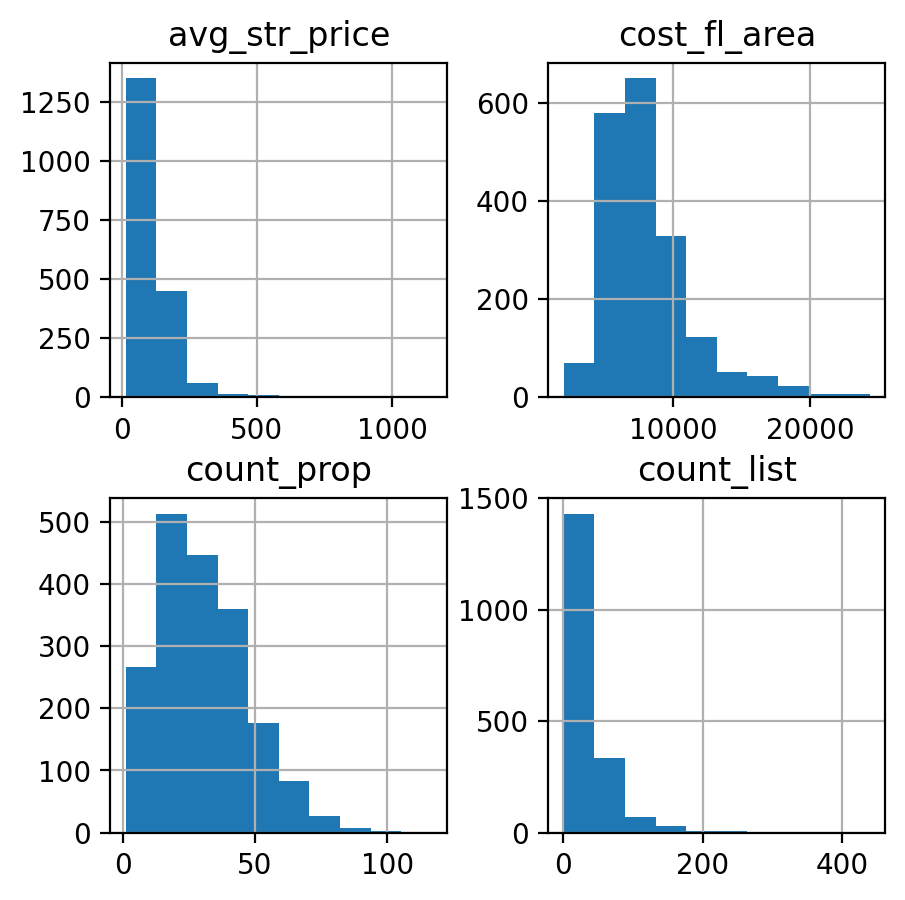

In [31]:
to_plot = ['avg_str_price', 'cost_fl_area', 'count_prop', 'count_list']
main_df_mod[to_plot].hist(figsize=(5, 5), bins=10)
plt.show()

In [32]:
# the group histogram suggests presence of outliers, so we get max vals for each numeric column
# function to get max values for specified columns
def get_max_vals(df):
  # get numeric colums only
  num_cols = df.select_dtypes(include='number').columns
  # get the maximum value for each numeric col and store in dictionary
  d_max = {}
  # for each column among num cols, get max and add to dict
  for col in num_cols:
    d_max[col] = df[col].max()
  return d_max

print(get_max_vals(main_df_mod))

{'avg_str_price': 1146.77, 'cost_fl_area': 24356.0, 'count_prop': 117, 'count_list': 440, 'imd_score': 59.0, 'income_score': 0.4, 'employ_score': 0.3, 'educ_score': 59.0, 'health_score': 1.6, 'crime_score': 2.1, 'house_score': 64.2, 'env_score': 91.6}


In [33]:
# calculate z_score and drop above +3 std dev
print("number of rows, pre-drop dataset: ", len(main_df_mod))

# get numeric columns
num_cols = main_df_mod.select_dtypes(include='number').columns
# for each numeric column
for col in num_cols:
  # calculate a z_score for row
  main_df_mod.loc[:, 'z_score'] = abs(zscore(main_df_mod[col]))
  # drop any z_score above 3
  main_df_mod = main_df_mod[main_df_mod['z_score'] <= 3].copy()

print("number of rows, post-drop dataset: ", len(main_df_mod))

number of rows, pre-drop dataset:  1885
number of rows, post-drop dataset:  1683


In [34]:
# print head as sanity check and drop z_score column, as has filled its purpose
main_df_mod.drop(columns='z_score', inplace=True)
main_df_mod.head(5)

,LSOA11CD,avg_str_price,cost_fl_area,count_prop,count_list,borough,imd_score,income_score,employ_score,educ_score,health_score,crime_score,house_score,env_score
4,E01000842,124.82,11701.46,24,34,Camden,8.5,0.1,0.0,5.4,-1.5,0.0,20.7,28.6
5,E01000843,149.86,11788.29,44,29,Camden,13.6,0.1,0.1,5.2,-1.4,0.0,22.1,33.5
6,E01000844,166.81,11944.08,33,32,Camden,9.8,0.1,0.0,1.4,-1.2,0.4,19.6,36.3
7,E01000845,113.89,12026.75,39,44,Camden,11.3,0.1,0.1,4.8,-0.9,0.6,16.4,25.2
8,E01000846,121.50,9918.79,10,16,Camden,22.1,0.2,0.1,7.1,-0.5,0.4,21.5,30.2


We now re-print the histograms to observe the data distribution for each of the sentinel features, and confirm that the outlier rows have indeed been removed.

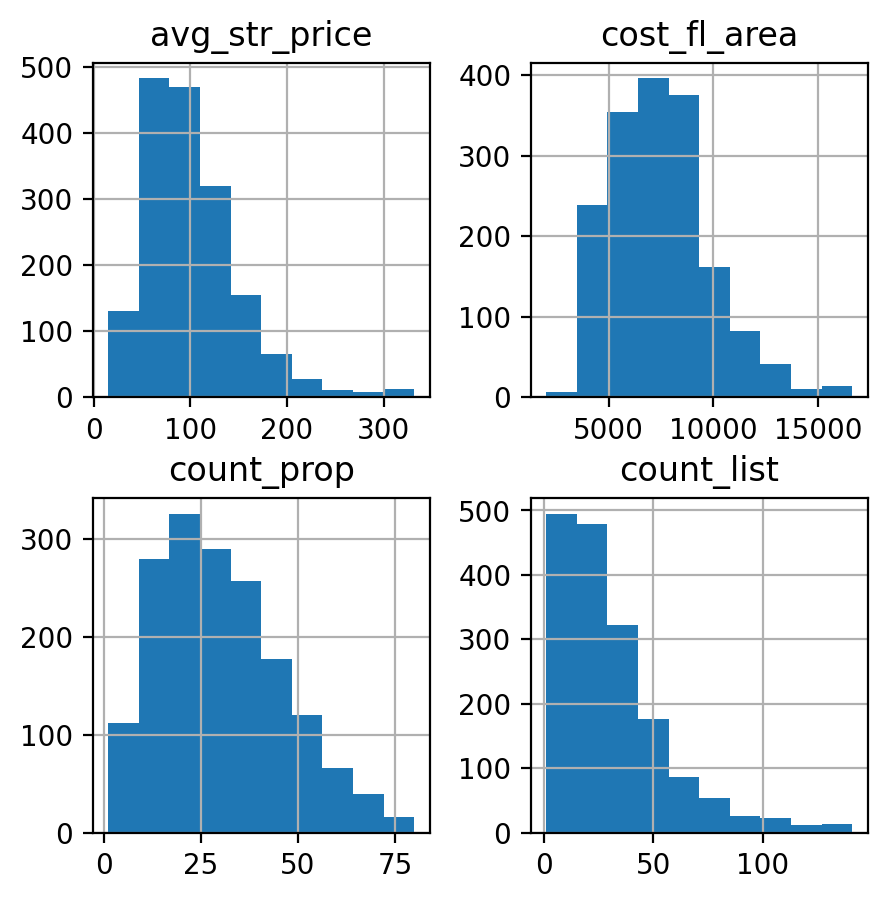

In [35]:
main_df_mod[to_plot].hist(figsize=(5, 5), bins=10)
plt.show()

**Random Forest Regression on modified dataframe:** We conduct the same modelling approach as before, using the modified dataframe `main_df_mod` as our basis for test, train dataset instantiation.

In [36]:
# generate independent variable - feature
mod_X = main_df_mod['count_list'].values
# generate dependent variable - target
mod_y = main_df_mod['cost_fl_area'].values

# split into test/train sets
X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(mod_X, mod_y, test_size=0.2, random_state=42)

#Random Forest Classifier
regr_mod = RandomForestRegressor()

# train the model
regr_mod.fit(X_train_mod.reshape(-1,1), y_train_mod.reshape(-1,1))

# make predictions
y_pred_mod = regr_mod.predict(X_test_mod.reshape(-1,1))

<ipython-input-36-165154bac7d6>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr_mod.fit(X_train_mod.reshape(-1,1), y_train_mod.reshape(-1,1))


We observe reduced MSE and RMSE scores from before. As a reminder, the respective scores from the prior Random Forest model without hyperparameter tuning was:
```
MSE: 7927624.175548098
RMSE: 2815.603696465129
```
We observe that even without hyper-parameter tuning, we have observed improvement by removing our outlier rows in data input. Visualization of the datapoints suggest reduction of the outliers, though a skew remains in the data.


In [37]:
# let's get the mse in order to evaluate performance
mse_mod = metrics.mean_squared_error(y_test_mod, y_pred_mod)

# root of mse - prediction error magnitude
rmse_mod = mse_mod**0.5

# print mean square error and root mean square deviation
print("Mean squared error, modified set without tuning: ", mse_mod)
print("Root mean squared error, modified set without tuning: ", rmse_mod)

Mean squared error, modified set without tuning:  4072824.3131075
Root mean squared error, modified set without tuning:  2018.123958806173


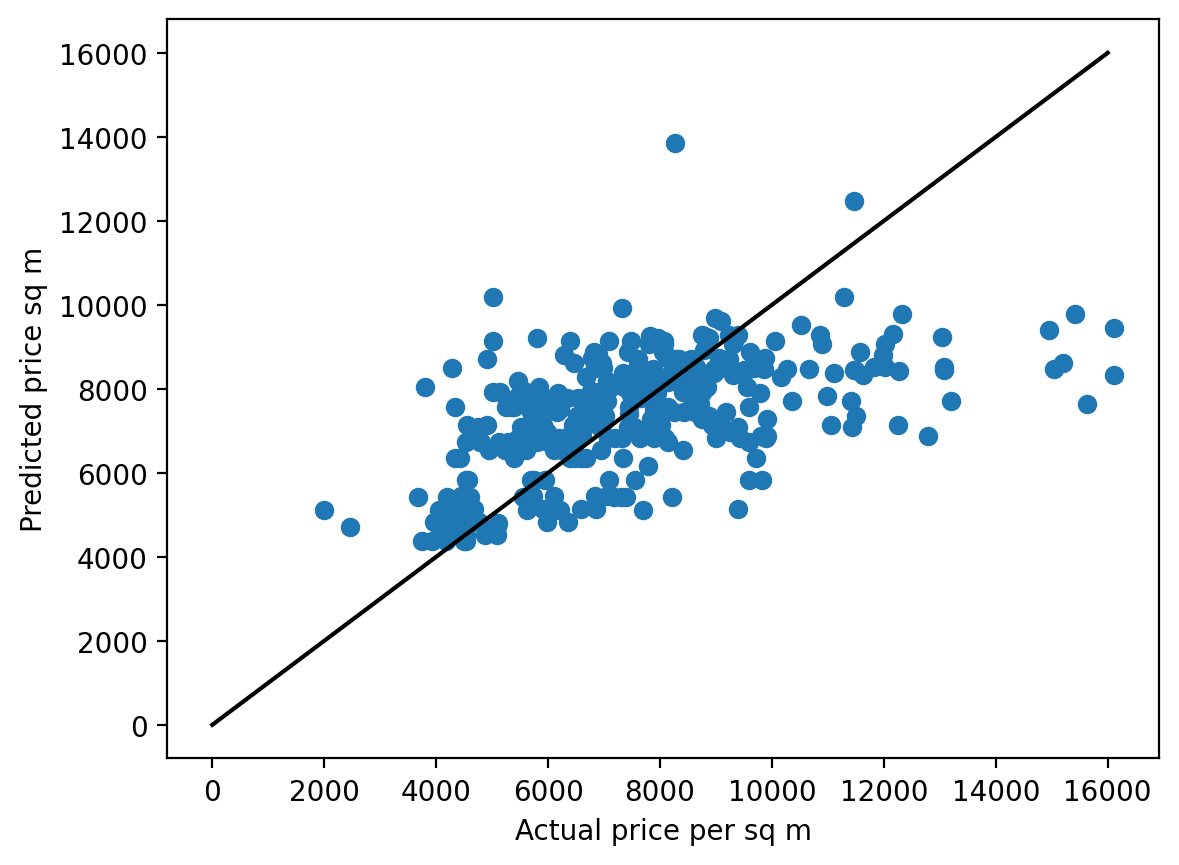

In [38]:
# let's visualize the predictions against the actual values

plt.scatter(y_test_mod, y_pred_mod)
plt.ylabel('Predicted price sq m')
plt.xlabel('Actual price per sq m')
plt.plot([0,16000], [0,16000], 'black')

Now, we rerun `GridSearchCV` as before to determine optimal hyperparameter values with which to guide our model development. We will use this as the basis to run our final iteration of the model.

In [41]:
# define grid search object given above params
grid_search_mod = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                           param_grid=param_grid,
                           cv = KFold(n_splits=3, shuffle=True, random_state=1),
                           scoring = "neg_mean_squared_error")

In [42]:
# run exhaustive grid search fitting to trial different hyperparameters
grid_search_mod.fit(X_train_mod.reshape(-1,1), y_train_mod.reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 10, 20], 'max_features': [5, 10, 20],
                         'n_estimators': [20, 50]},
             scoring='neg_mean_squared_error')

In [43]:
# Let's take a look at the best parameters that GridSearchCV found for our data
grid_search_mod.best_params_

{'max_depth': 5, 'max_features': 5, 'n_estimators': 50}

In [44]:
# Let's use the best model for our predictions
predict_mod = grid_search_mod.predict(X_test_mod.reshape(-1,1))

In [45]:
mse_mod = mean_squared_error(y_test_mod, predict_mod)
rmse_mod = mse_mod**0.5

print("Mean squared error, modified set with tuning: ", mse_mod)
print("Root mean squared error, modified set with tuning: ", rmse_mod)
# mse not very different from our original mse

Mean squared error, modified set with tuning:  3787887.054358972
Root mean squared error, modified set with tuning:  1946.2494840998602


In [46]:
rfm_score = metrics.r2_score(y_test_mod, y_pred_mod)
print("R-squared score, modified set with tuning: ", rfm_score)

R-squared score, modified set with tuning:  0.3098163294806344


```
Prior low scores (tuned model with dataset including outliers)
MSE: 6791149.9363204595
RMSE: 2605.9834873460845
```
**Conclusion:** By managing outlying data through iterative EDA and cleaning, we have observed an improvement in both MSE and RMSE scores, with improved performance from the tuned model with outliers. The error margin remains stubbornly greater than we'd like, with an average error per estimate of 1,946.25.

As the majority of STR listings are found within the inner London geographic area, we posit that expanding the scope of LSOA to all of Greater London would not be particularly helpful with respect to our model.

Instead, we posit the overall training error could be improved by broadening the time-series of property data and STR listings from the study's three-year 2017-2019 period to a five to 10 year range. This is reserved as a future direction for study.